In [1]:
%matplotlib notebook
from python_app.sp_digitiser import SpDigitiser
from python_app.power_pipeline import PowerPipeline
from python_app.g1_pipeline import G1Pipeline
from python_app.utils import file_ops
import os
import matplotlib.pyplot as plt

In [ ]:
# Kernel must be relaunched if running in jupyter notebook in order to free the dll library being used
os._exit(0)

# Power measurements

POWER-PIPELINE: Building kernel with:
SP_POINTS=400
🗑  Cleaning build objects
removed ‘./build/src/g1_kernel_cpu_direct.o’
removed ‘./build/src/g1_kernel_cpu_fftw.o’
removed ‘./build/src/g1_kernel_cpu_preprocessor.o’
removed ‘./build/src/g1_kernel_gpu_fftw.o’
removed ‘./build/src/g1_kernel_gpu_preprocessor.o’
removed ‘./build/src/g1_kernel_gpu_utils.o’
removed ‘./build/src/g1_pipeline.o’
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=400 -D G1_DIGITISER_POINTS=254200

🍕 [cpp] Building src/g1_kernel_cpu_preprocessor.cpp ⟶ build/./src/g1_kernel_cpu_preprocessor.o
🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cp

<IPython.core.display.Javascript object>


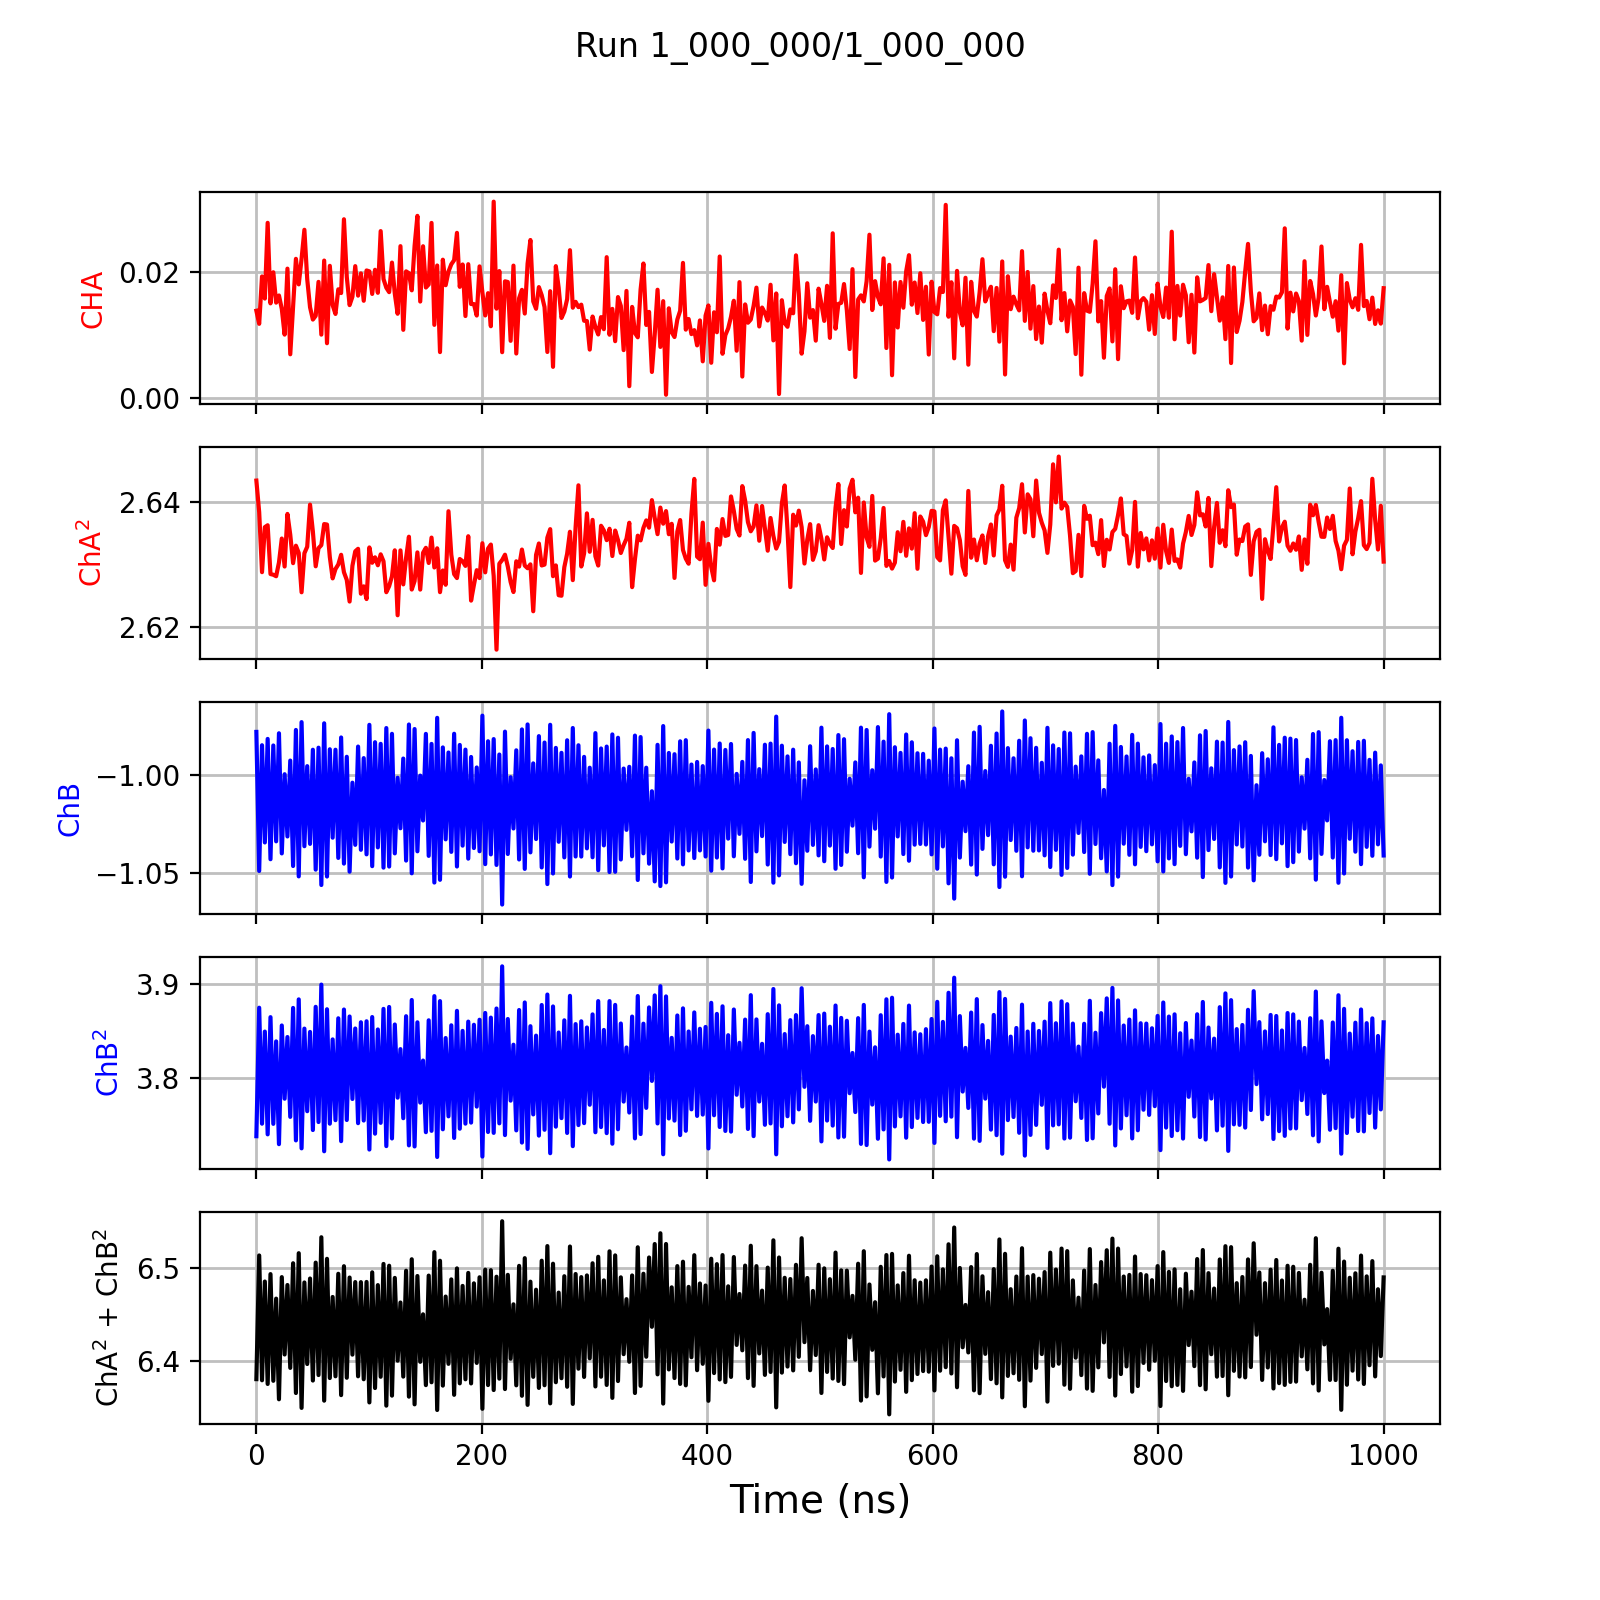

SP-DIGITISER:   🌟 Connected to digitiser.


In [2]:
SP_POINTS = 400

pp = PowerPipeline(
    ipython=True,
    SP_POINTS=SP_POINTS,
#     recompile=False
)

In [4]:
RUN_NAME = "repetition-5MHz_width-180ns"
NO_RUNS = 1_000_000

chA_background=None; chB_background=None
# (chA_background, chB_background) = file_ops.load_chA_chB_arrays("./dump/ttt.csv")

pp.execute_run(
    NO_RUNS=NO_RUNS,
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
#         "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 53,
        "channelB_offset": 38,
#         "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_EXTERNAL_10MHZ_REFFERENCE
    },
    run_name=RUN_NAME,
    chA_background=chA_background, chB_background=chB_background
)

SP-DIGITISER:   
Max Samples for (r_points=147168): 520
Max Records for (sp_points=400): 147168
SP-DIGITISER:   Max Trigger frequency: 340kHz
SP-DIGITISER:   External clock source used!
SP-DIGITISER:   External trigger used!
POWER-PIPELINE: Measurements started
POWER-PIPELINE: Measurements done -> data dumped to ./store/repetition-5MHz_width-180ns.csv


# G1 measurements
- **Tau points** to evaluate the correlation for. Starting from 0

G1-PIPELINE:    Building kernel with:
TAU_POINTS=1000


<IPython.core.display.Javascript object>


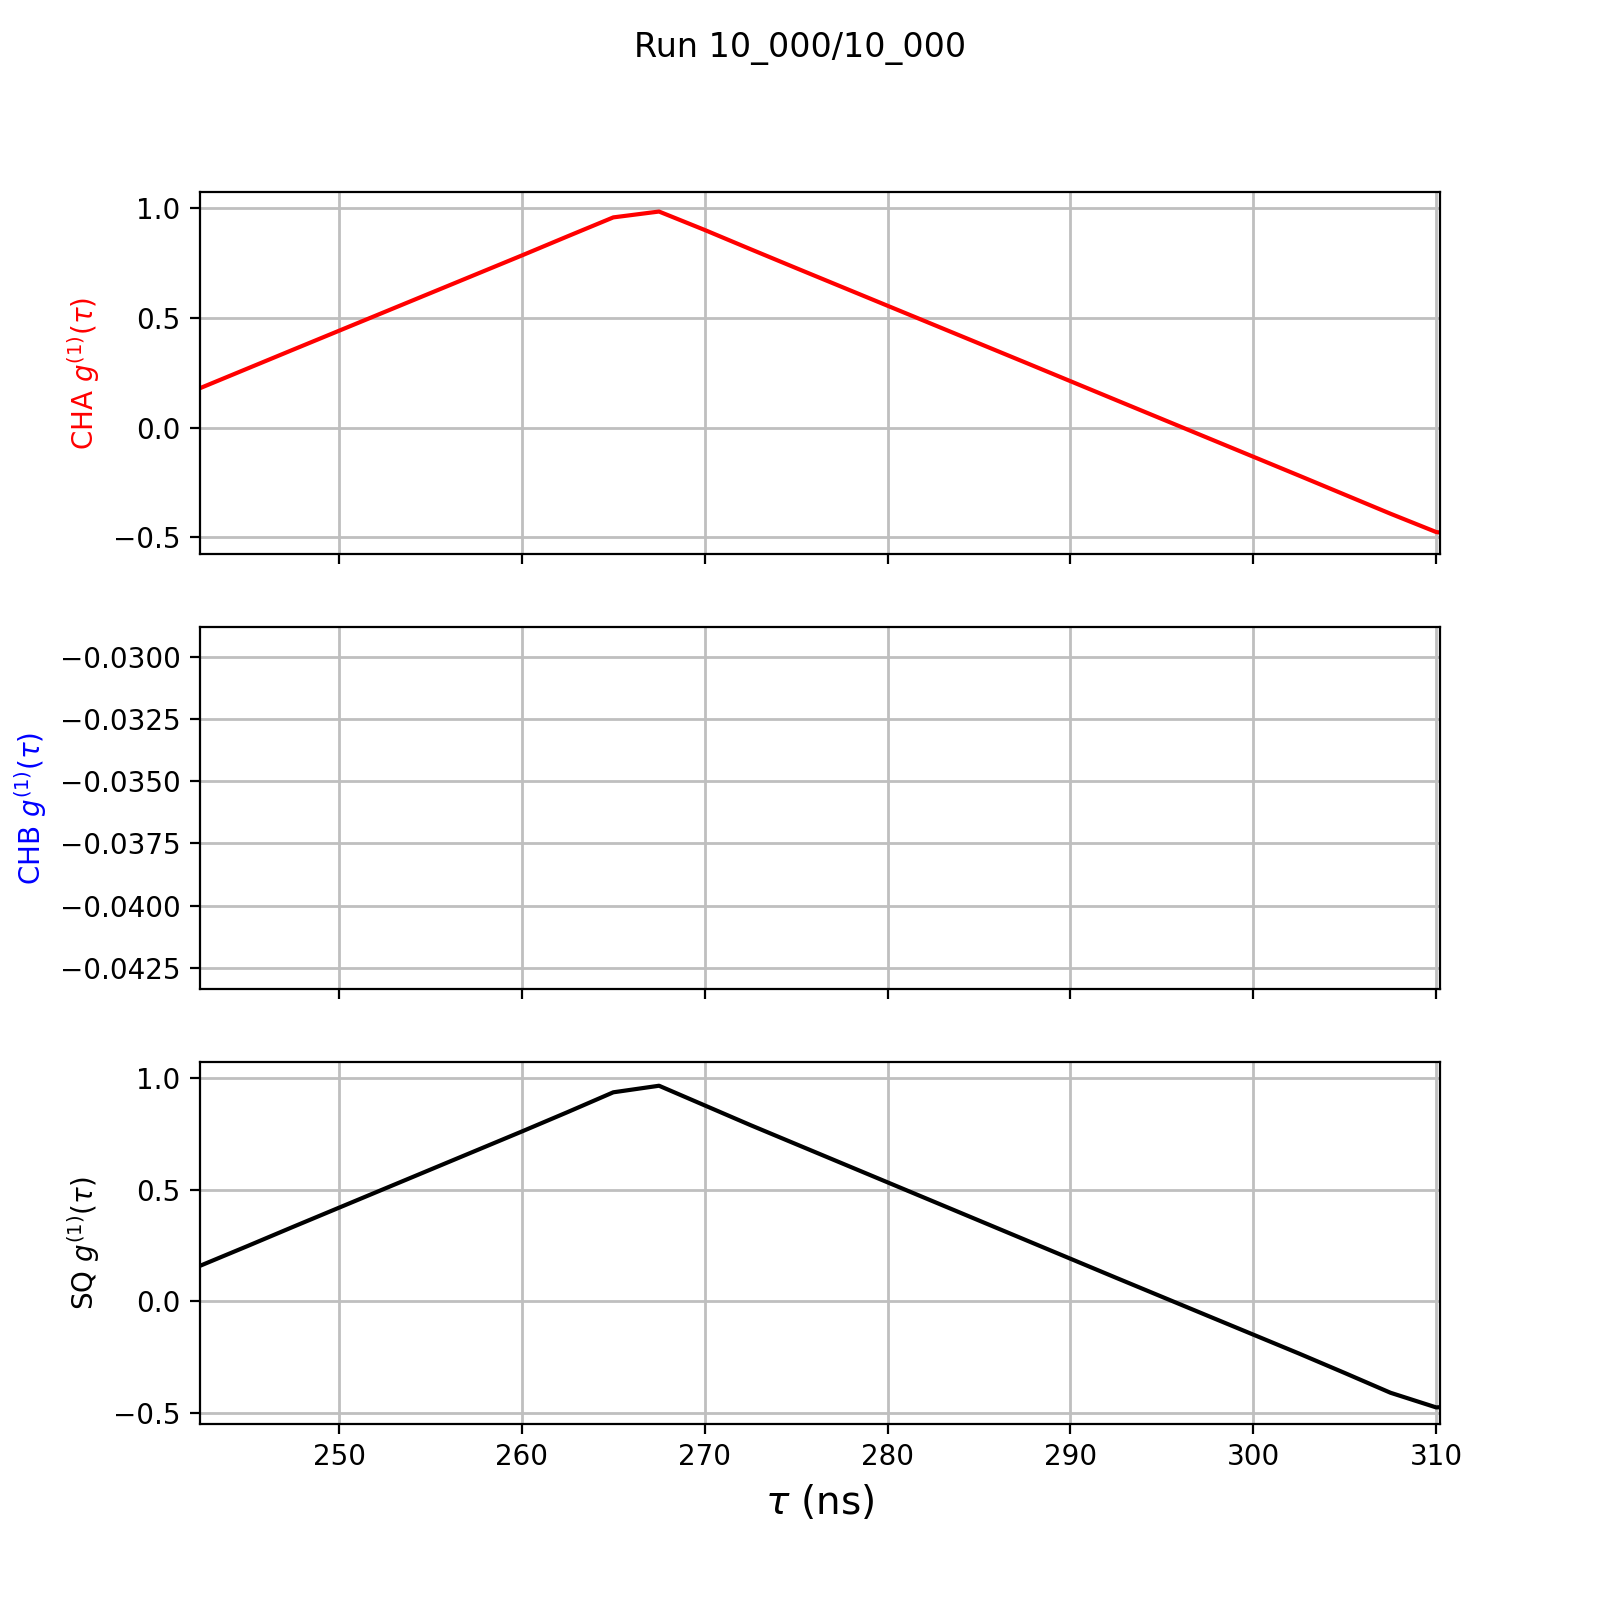

SP-DIGITISER:   🌟 Connected to digitiser.


In [2]:
TAU_POINTS = 1000

pp = G1Pipeline(
    ipython=True,
    TAU_POINTS=TAU_POINTS,
    recompile=False
)

In [4]:
RUN_NAME = "g1_test"

pp.execute_run(
    NO_RUNS= 10000,
    digitiser_parameters={
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 53,
        "channelB_offset": 38,
#         "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_EXTERNAL_10MHZ_REFFERENCE
    },
    run_name=RUN_NAME
)

SP-DIGITISER:   
Max Samples for (r_points=1): 289262
Max Records for (sp_points=254200): 301
SP-DIGITISER:   Max Trigger frequency: 6.1kHz
SP-DIGITISER:   External clock source used!
SP-DIGITISER:   External trigger used!
G1-PIPELINE:    Measurements started
G1-PIPELINE:    Measurements done -> data dumped to ./store/g1_test.csv


# Testing Data Generation

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)

In [16]:
9755654/3218

3031.5891858297077

In [15]:
(CHA[0] + CHA[1] + CHA[2])

-4760

In [7]:
R_POINTS = 128000
SP_POINTS = 400
OFFSET = 2**13
MULTIPLIER = 2**14

CHA = [int(x * MULTIPLIER - OFFSET) for x in np.random.rand(SP_POINTS)]
CHB = [int(x * MULTIPLIER - OFFSET) for x in np.random.rand(SP_POINTS)]
SQ = np.power(CHA, 2) + np.power(CHB, 2)

# CHA_data = np.tile(CHA, R_POINTS)
# CHB_data = np.tile(CHB, R_POINTS)

In [9]:
np.savetxt("./csrc/test/test_files/power_test_data.txt", np.c_[CHA, CHB, SQ], fmt="%i")

## G1

In [ ]:
def correlation_runner(input_array, var, n, tau, biased):
      """Cross multiplication of the array by itself, with a shift
      Note that the same normalisation N is applied irrespective.
      See https://en.wikipedia.org/wiki/Correlogram on why we may divide by N instead of n-tau    """
      normalisation = n
      if biased == False:
          normalisation = n - tau

      return (
          ((input_array[: n - tau]) * (input_array[tau:])).sum()
          / var
          / normalisation
      )

def correlation(input_array, tau_list, biased):
    input_array -= np.average(input_array)
    var = np.var(input_array)
    n = len(input_array)
    
    return [correlation_runner(input_array, var, n, tau, biased) for tau in tau_list]

In [7]:
SIZE = 262140
OFFSET = 2**13
MULTIPLIER = 2**14

CHA = [(x * MULTIPLIER - OFFSET) for x in np.random.rand(SIZE)]
CHB = [(x * MULTIPLIER - OFFSET) for x in np.random.rand(SIZE)]
SQ = np.power(CHA, 2) + np.power(CHB, 2)
np.savetxt("g1_test_data.txt", np.c_[CHA, CHB, SQ], fmt="%i")

print(np.mean(CHA))
print(np.mean(CHB))
print(np.mean(SQ))

print(np.var(CHA))
print(np.var(CHB))
print(np.var(SQ))

7.950247483262897
-4.430522148000995
44702389.40396311
22355718.64064403
22346587.927357536
799664705005884.9


In [ ]:
# Sanity check
input_array = CHA
tau_list = np.arange(100)
OUTPUT_ARRAY = correlation(input_array, tau_list, True)

pd.plotting.autocorrelation_plot(input_array)
plt.plot(tau_list, OUTPUT_ARRAY,
           linewidth=0.4,
           marker="o")
plt.show()

In [ ]:
tau_list = np.arange(200)
CHAG1 = correlation(CHA, tau_list, True)
CHBG1 = correlation(CHB, tau_list, True)
SQG1 = correlation(SQ, tau_list, True)
np.savetxt("g1_expected_biased_normalisation.txt", np.c_[CHAG1, CHBG1, SQG1], fmt="%.6f")

In [ ]:
biased = False
CHAG1 = correlation(CHA, tau_list, biased)
CHBG1 = correlation(CHB, tau_list, biased)
SQG1 = correlation(SQ, tau_list, biased)
np.savetxt("g1_expected_unbiased_normalisation.txt", np.c_[CHAG1, CHBG1, SQG1], fmt="%.6f")

# Benchmarking

<IPython.core.display.Javascript object>


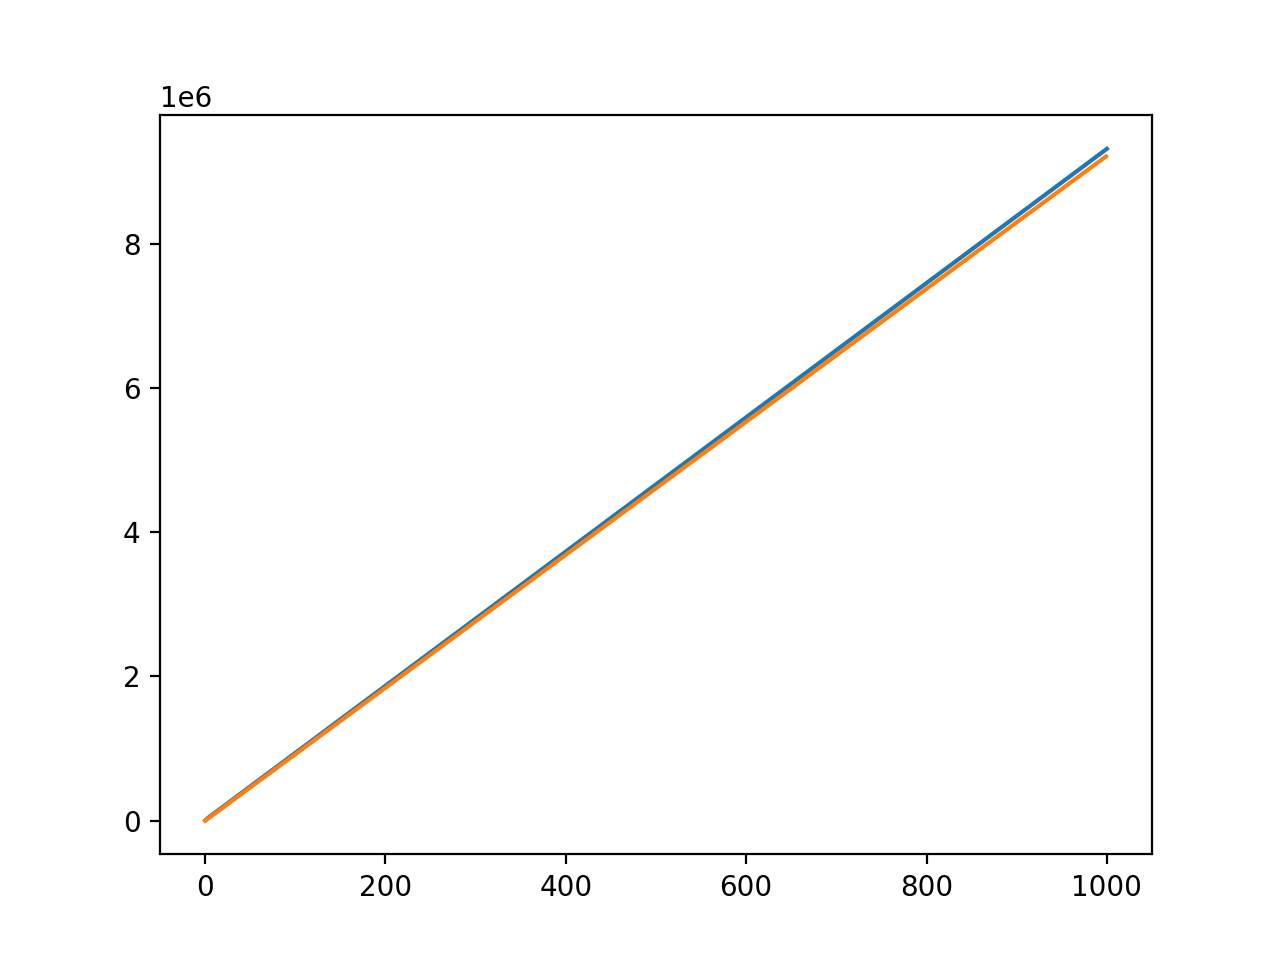

In [21]:
plt.plot(
    [1, 2, 3, 4, 5, 1000], 
    [13970.00000, 25372.02500, 37119.19231, 47468.45000, 57202.00000, 9313858.00000]
)

x = np.arange(0, 1000)
plt.plot(x, x*9217.11364)

# Debug

## Fetching from digitiser

In [2]:
%matplotlib notebook
import ctypes
import numpy as np
import python_app.utils.library_manager as library_manager
from python_app.sp_digitiser import SpDigitiser
import matplotlib.pyplot as plt

# library_manager.build_library({}, "libadq")
ADQAPIia = ctypes.cdll.LoadLibrary("./csrc/bin/ADQAPIia.so")
ADQAPI = ctypes.cdll.LoadLibrary("libadq.so")

In [3]:
# R_POINTS = 128000
# SP_POINTS = 400
R_POINTS = 1
SP_POINTS = 100

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE
    }
)

chA_buff = np.zeros(SP_POINTS, dtype=np.short)
chB_buff = np.zeros(SP_POINTS, dtype=np.short)

assert ADQAPI.ADQ214_MultiRecordSetup(
    spd.adq_cu_ptr,
    1,
    R_POINTS,
    SP_POINTS,
)

SP-DIGITISER:   
Max Samples for (r_points=1): 254200
Max Records for (sp_points=100): 254200
SP-DIGITISER:   Max Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!


In [4]:
print(spd.get_max_noSamples_from_noRecords(128000))
print(spd.get_max_noRecords_from_noSamples(10000))

597

In [4]:
ADQAPIia.fetch_digitiser_data(
    spd.adq_cu_ptr,
    chA_buff.ctypes.data, chB_buff.ctypes.data,
    SP_POINTS,
    R_POINTS
)

1

<IPython.core.display.Javascript object>


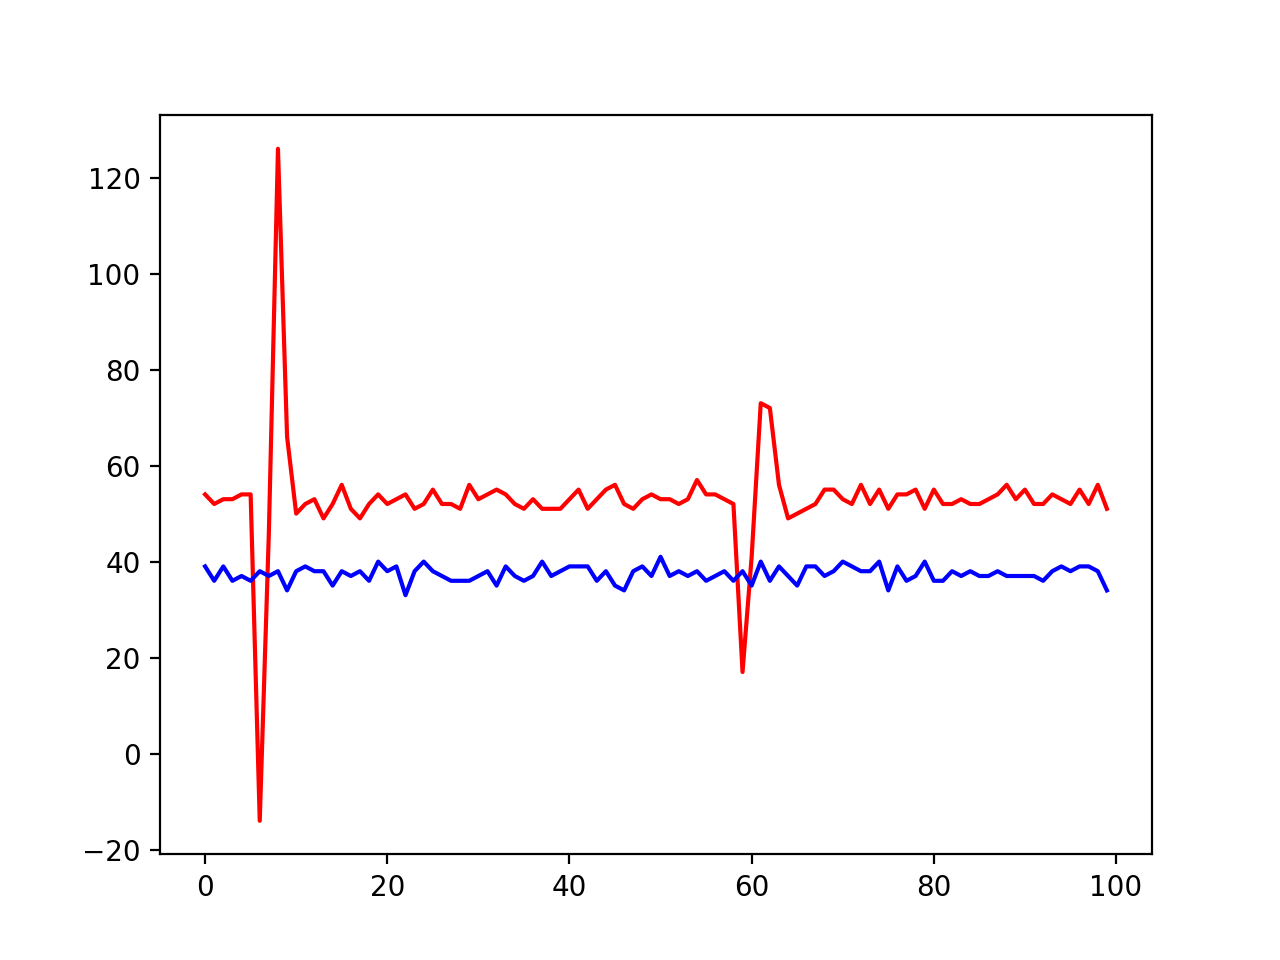

In [5]:
fix, ax = plt.subplots(1)
ax.plot(chA_buff, color="red")
ax.plot(chB_buff, color="blue")

## Library testing

In [1]:
import ctypes

import numpy as np
from python_app.sp_digitiser import SpDigitiser
from python_app.utils import library_manager

LIBRARY_LOCATION = "./csrc/bin/libia.so"
SP_POINTS = 20
R_POINTS = 2
R_POINTS_PER_GPU_CHUNK = 1

In [2]:
library_manager.build_library(
    {
        "R_POINTS_PER_GPU_CHUNK": str(R_POINTS_PER_GPU_CHUNK),
        "SP_POINTS": str(SP_POINTS),
        "R_POINTS": str(R_POINTS),
    }
)

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=20 -D R_POINTS=2 -D R_POINTS_PER_GPU_CHUNK=1

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Building src/logging.cpp ⟶ build/./src/logging.o
🍕 [cpp] Building src/power_pipeline.cpp ⟶ build/./src/power_pipeline.o


In [2]:
chA = np.ones(SP_POINTS, dtype=np.short)

chB = np.ones(SP_POINTS, dtype=np.short)

In [3]:
libia = ctypes.cdll.LoadLibrary(LIBRARY_LOCATION)

chA[0] = 30
chA[1] = 40
print(chA.ctypes.data)
# for (i, _) in enumerate(chA):
#     chA[i] = i
# for (i, _) in enumerate(chB):
#     chB[i] = i-2

spd = SpDigitiser(
    {
        "r_points": R_POINTS,
        "sp_points": SP_POINTS,
        "delay": 0,
        "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
        #     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
        "channelA_gain": 1,
        "channelB_gain": 1,
        "channelA_offset": 0,
        "channelB_offset": 0,
        "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
        "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
    }
)

21137328
SP-DIGITISER:   Trigger frequency: 1300kHz
SP-DIGITISER:   External trigger used!
SP-DIGITISER:   0


In [6]:
library_manager.HANDLE_CPP_ERROR(
    libia.run_power_measurements(
        spd.adq_cu_ptr,
        chA.ctypes.data, chB.ctypes.data,
        1,
        ctypes.create_string_buffer("./debug-run.csv".encode("utf-8"), size=40)
    )
)